### Imports

In [1]:
import torch
from torch import nn
from read_data import read_data
from preproc import *
from dataloader import get_dls, Dataset
from model import Model,model_output
from training_loop import training_loop


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
np.random.seed(777)

In [4]:
from utils import f1score

In [5]:
training_sentence_tags = read_data('data/train.txt')
valid_sentence_tags = read_data('data/valid.txt')
vocabtoidx, labeltoidx = vocab_to_idx(training_sentence_tags)
dataset_train = Dataset(list(prepare_batch(training_sentence_tags, vocabtoidx, labeltoidx)))
dataset_valid = Dataset(list(prepare_batch(valid_sentence_tags, vocabtoidx, labeltoidx)))

### Ablation Studies

In [6]:
def train(bs=32,emb=50,hs=50):
    train_dl = get_dls(dataset_train, bs)
    valid_dl = get_dls(dataset_valid, bs)
    net = Model(vocabtoidx, len(labeltoidx),emb, hs).to("cuda")
    loss_func = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(net.parameters(),lr=1e1)
    training_loop(net, opt, loss_func, 5, train_dl, valid_dl,0)
    correct,predicted=model_output(net,valid_dl)
    return f1score(correct.cpu(),predicted.cpu())
    

####  Changing Batch Size

In [7]:
f1_scores=[]
for bs in [16,32,64,128,256,512]:
    score=train(bs=bs)
    f1_scores.append(score)
    print(f1_scores[-1])

0.8816264008996783
0.9081320044983906
0.8810834916818552
0.8588436033660372
0.8425563268313492
0.8376701438709427


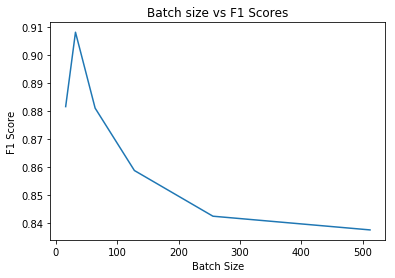

In [8]:
fig,ax=plt.subplots(1)
ax.plot([16,32,64,128,256,512],f1_scores)
ax.set_title("Batch size vs F1 Scores")
ax.set_xlabel("Batch Size")
ax.set_ylabel("F1 Score");

#### Hidden Size

In [9]:
f1_scores=[]
for hs in [16,32,64,128,256,512]:
    score=train(hs=hs,bs=16)
    f1_scores.append(score)
    print(f1_scores[-1])

0.8838949858455811
0.9070461860627448
0.9091984333191143
0.9207158645829294
0.9206189165083182
0.8060844611626014


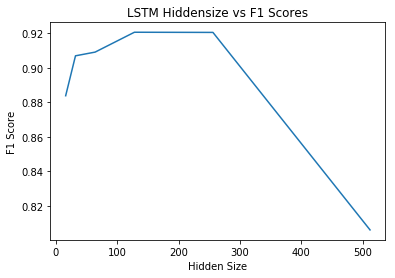

In [10]:
fig,ax=plt.subplots(1)
ax.plot([16,32,64,128,256,512],f1_scores)
ax.set_title("LSTM Hiddensize vs F1 Scores")
ax.set_xlabel("Hidden Size")
ax.set_ylabel("F1 Score");

#### Embedding size

In [11]:
f1_scores=[]
for emb in [16,32,64,128,256,512]:
    score=train(emb=emb,bs=16,hs=128)
    f1_scores.append(score)
    print(f1_scores[-1])

0.8745879706829023
0.9050102764959088
0.9233916314421996
0.930313723969442
0.9276379571101718
0.9272889440415714


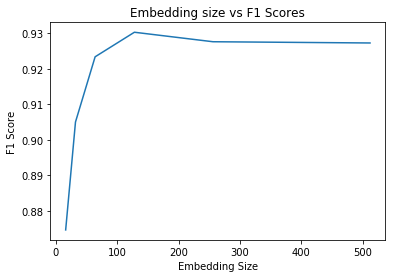

In [12]:
fig,ax=plt.subplots(1)
ax.plot([16,32,64,128,256,512],f1_scores)
ax.set_title("Embedding size vs F1 Scores")
ax.set_xlabel("Embedding Size")
ax.set_ylabel("F1 Score");

In [13]:
from utils import classificationreport

In [14]:
train_dl = get_dls(dataset_train, 16)
valid_dl = get_dls(dataset_valid, 16)
net = Model(vocabtoidx, len(labeltoidx),128, 128).to("cuda")
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(),lr=1e1)
training_loop(net, opt, loss_func, 5, train_dl, valid_dl,0)
correct,predicted=model_output(net,valid_dl)

In [15]:
print(classificationreport(correct.cpu(),predicted.cpu()))

              precision    recall  f1-score   support

           1       0.95      0.98      0.97     42973
           2       0.56      0.62      0.59      1340
           3       0.80      0.62      0.70       922
           4       0.85      0.56      0.67      1842
           5       0.88      0.46      0.61      1307
           6       0.81      0.74      0.77      1837
           7       0.40      0.57      0.47       750
           8       0.81      0.55      0.66       346
           9       0.74      0.68      0.71       257

   micro avg       0.92      0.92      0.92     51574
   macro avg       0.76      0.64      0.68     51574
weighted avg       0.92      0.92      0.92     51574



#### Using Fasttext Word embeddings

Since we are using pretrained word embeddings  
It is better to use a smaller learning rate, and more epochs

In [16]:
net = Model(vocabtoidx, len(labeltoidx),128, 128,pretrained=True).to("cuda")
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(),lr=1e-1)
training_loop(net, opt, loss_func, 10, train_dl, valid_dl,0)
correct,predicted=model_output(net,valid_dl)

In [17]:
print(classificationreport(correct.cpu(),predicted.cpu()))

              precision    recall  f1-score   support

           1       0.95      1.00      0.97     42973
           2       0.66      0.56      0.61      1340
           3       0.80      0.42      0.55       922
           4       0.92      0.73      0.82      1842
           5       0.93      0.75      0.83      1307
           6       0.83      0.73      0.78      1837
           7       0.51      0.57      0.54       750
           8       0.80      0.03      0.07       346
           9       0.62      0.03      0.06       257

   micro avg       0.93      0.93      0.93     51574
   macro avg       0.78      0.54      0.58     51574
weighted avg       0.93      0.93      0.92     51574



UnFreeze Pretrained Embeds

In [18]:
net = Model(vocabtoidx, len(labeltoidx),128, 128,pretrained=True,freeze=False).to("cuda")
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(),lr=1e-1)
training_loop(net, opt, loss_func, 10, train_dl, valid_dl,0)
correct,predicted=model_output(net,valid_dl)

In [19]:
print(classificationreport(correct.cpu(),predicted.cpu()))

              precision    recall  f1-score   support

           1       0.96      1.00      0.98     42973
           2       0.71      0.62      0.66      1340
           3       0.81      0.55      0.65       922
           4       0.94      0.73      0.82      1842
           5       0.94      0.76      0.84      1307
           6       0.86      0.75      0.80      1837
           7       0.55      0.60      0.57       750
           8       0.88      0.11      0.20       346
           9       0.67      0.05      0.09       257

   micro avg       0.94      0.94      0.94     51574
   macro avg       0.81      0.57      0.62     51574
weighted avg       0.94      0.94      0.93     51574

